# Incredible TPUs - finetune EffNetB0-B6 at once

> ### **Updated on 2020-06-27**
> * Fix: generating of submission files for single models
> * Change: reverted TTA repeats to 25. Local tests showed 20-25 repeats are enough for used augmentation pipeline.

> ### **Updated on 2020-06-22**
> * Fix: description of used dataset
> * Change: more code cleaning
> * Change: increased TTA repeats to 50 and using batchsize 256 * 8 replicas (=2048 total batchsize !!)


### Following notebook uses:
* Tensorflow and TPUs
* 224x224 sized pretrained EfficientNetB0 to B6 combined into one huge model -> Total params: 116,336,013 (!!) 
* The scaled down dataset [Melanoma TFRecords 256x256](https://www.kaggle.com/cdeotte/melanoma-256x256) from Chris Deotte - Thank you :-)
* Multiple image augmentations, including rotation, shear, color, contrast, random cropping, ....
* TTA (Test time augmentation) with 50 repeats, done in one predict()-call with repeated test dataset
* BCE (Binary Crossentropy) with a label smoothing factor of 0.05

Internally all pretrained CNNs are combined into a single Model, with a single input (=image) and multiple outputs, one "normal" output with BCE-loss for each "sub"-network.

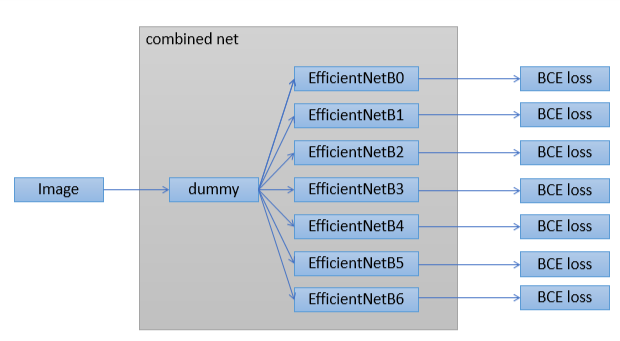

### There is **only one model.fit()** and **only one model.predict()** call. Is this a "single model"-model?!  ;-)

I do not know if this is a feasable approach to use TPUs in a efficient way. The preparation time in the first epoch is huge >15min. It seams you gain nothing compared to sequentially training of the models, but I did not measure and compare it.

In [1]:
DEVICE = "TPU"

CFG = dict(
    net_count         =   7,
    batch_size        =  16,
    
    read_size         = 256, 
    crop_size         = 250, 
    net_size          = 224, 
    
    LR_START          =   0.000005,
    LR_MAX            =   0.000020,
    LR_MIN            =   0.000001,
    LR_RAMPUP_EPOCHS  =   5,
    LR_SUSTAIN_EPOCHS =   0,
    LR_EXP_DECAY      =   0.8,
    epochs            =  12,
    
    rot               = 180.0,
    shr               =   2.0,
    hzoom             =   8.0,
    wzoom             =   8.0,
    hshift            =   8.0,
    wshift            =   8.0,

    optimizer         = 'adam',
    label_smooth_fac  =   0.05,
    
    tta_steps         =  25    
)

In [2]:
!pip install -q efficientnet

In [3]:
import os, random, re, math, time
random.seed(a=42)

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

import PIL

from kaggle_datasets import KaggleDatasets

from tqdm import tqdm

In [4]:
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-256x256')
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [6]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, cfg):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg["read_size"]
    XDIM = DIM%2 #fix for size 331
    
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [7]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, cfg=None, augment=True):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)

    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [8]:
def get_dataset(files, cfg, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(cfg['batch_size'] * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

## Test the input pipeline
Before calling any neural net I always test the input pipeline.
Here are images from the train data.

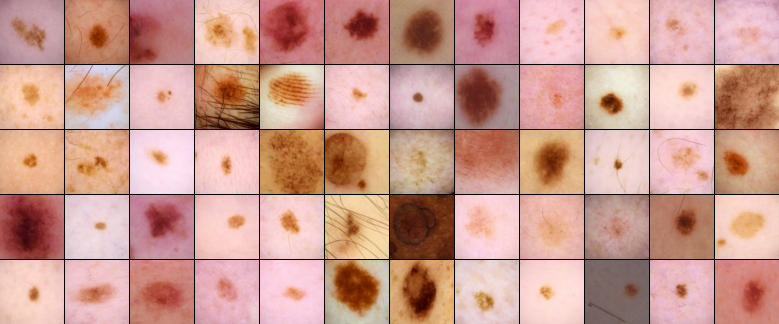

In [9]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)
    
ds = get_dataset(files_train, CFG).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

## Test of image augmentation

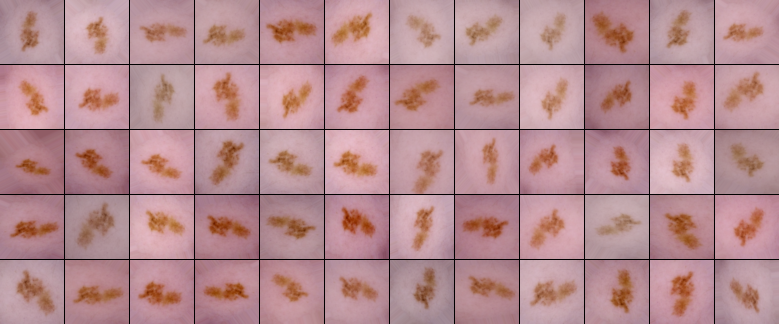

In [10]:
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target: (prepare_image(img, cfg=CFG, augment=True), target), 
            num_parallel_calls=AUTO)
ds = ds.take(12*5)
ds = ds.prefetch(AUTO)

show_dataset(64, 12, 5, ds)

## Images from the test data

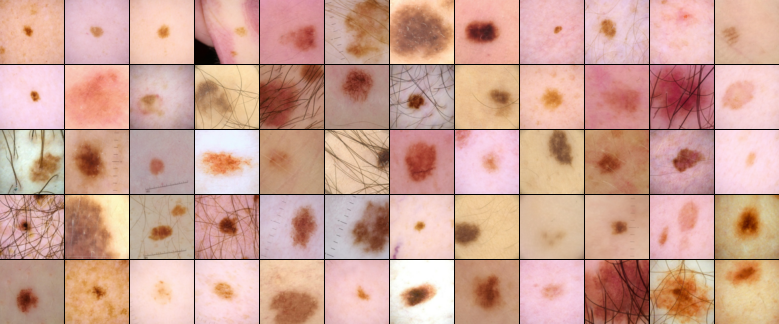

In [11]:
ds = get_dataset(files_test, CFG, labeled=False).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

In [12]:
def get_lr_callback(cfg):
    lr_start   = cfg['LR_START']
    lr_max     = cfg['LR_MAX'] * strategy.num_replicas_in_sync
    lr_min     = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep  = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay   = cfg['LR_EXP_DECAY']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [13]:
def get_model(cfg):
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='imgIn')

    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    
    outputs = []    
    for i in range(cfg['net_count']):
        constructor = getattr(efn, f'EfficientNetB{i}')
        
        x = constructor(include_top=False, weights='imagenet', 
                        input_shape=(cfg['net_size'], cfg['net_size'], 3), 
                        pooling='avg')(dummy)
        
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        outputs.append(x)
        
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    return model

In [14]:
def compile_new_model(cfg):    
    with strategy.scope():
        model = get_model(cfg)
     
        losses = [tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac'])
                  for i in range(cfg['net_count'])]
        
        model.compile(
            optimizer = cfg['optimizer'],
            loss      = losses,
            metrics   = [tf.keras.metrics.AUC(name='auc')])
        
    return model

In [15]:
ds_train     = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
ds_train     = ds_train.map(lambda img, label: (img, tuple([label] * CFG['net_count'])))

steps_train  = count_data_items(files_train) / (CFG['batch_size'] * REPLICAS)

model        = compile_new_model(CFG)
history      = model.fit(ds_train, 
                         verbose          = 1,
                         steps_per_epoch  = steps_train, 
                         epochs           = CFG['epochs'],
                         callbacks        = [get_lr_callback(CFG)])

165527552/165527152 [==============================] - 6s 0us/step
Model: "aNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imgIn (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           imgIn[0][0]                      
__________________________________________________________________________________________________
efficientnet-b0 (Model)         (None, 1280)         4049564     lambda[0][0]                     
__________________________________________________________________________________________________
efficientnet-b1 (Model)         (None, 1280)         6575232     lambda[0][0]                     
________________________

### predict the test set using augmented images

In [16]:
CFG['batch_size'] = 256

cnt_test   = count_data_items(files_test)
steps      = cnt_test / (CFG['batch_size'] * REPLICAS) * CFG['tta_steps']
ds_testAug = get_dataset(files_test, CFG, augment=True, repeat=True, 
                         labeled=False, return_image_names=False)

probs = model.predict(ds_testAug, verbose=1, steps=steps)

probs = np.stack(probs)
probs = probs[:,:cnt_test * CFG['tta_steps']]
probs = np.stack(np.split(probs, CFG['tta_steps'], axis=1), axis=1)
probs = np.mean(probs, axis=1)

135/134 [==============================] - 188s 1s/step


### sort predictions to have the same order as the submission
The submission ist sorted by image_name, but the dataset yielded a different order.
Traverse the test dataset once again and capture the image_names. Then join this list of image_names with the predictions and sort by image_name.

In [17]:
ds = get_dataset(files_test, CFG, augment=False, repeat=False, 
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

### write a submission file for each submodel

In [18]:
for i in range(CFG["net_count"]):
    submission = pd.DataFrame(dict(
        image_name = image_names,
        target     = probs[i,:,0]))

    submission = submission.sort_values('image_name') 
    submission.to_csv(f'submission_model_{i}.csv', index=False)

### write a submission file using the mean of all submodels

In [19]:
submission = pd.DataFrame(dict(
    image_name = image_names,
    target     = np.mean(probs[:,:,0], axis=0)))

submission = submission.sort_values('image_name') 
submission.to_csv('submission_models_blended.csv', index=False)

In [20]:
!ls -l .

total 2192
---------- 1 root root  68639 Jun 27 17:58 __notebook__.ipynb
-rw-r--r-- 1 root root 270115 Jun 27 19:16 submission_model_0.csv
-rw-r--r-- 1 root root 269980 Jun 27 19:16 submission_model_1.csv
-rw-r--r-- 1 root root 270346 Jun 27 19:16 submission_model_2.csv
-rw-r--r-- 1 root root 270051 Jun 27 19:16 submission_model_3.csv
-rw-r--r-- 1 root root 270464 Jun 27 19:16 submission_model_4.csv
-rw-r--r-- 1 root root 269858 Jun 27 19:16 submission_model_5.csv
-rw-r--r-- 1 root root 270357 Jun 27 19:16 submission_model_6.csv
-rw-r--r-- 1 root root 270247 Jun 27 19:16 submission_models_blended.csv
